<a href="https://colab.research.google.com/github/Quantyca/DeepLearning/blob/master/Lesson1_italianfood_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 1 - Italian food [Video della lezione](https://www.youtube.com/watch?v=BWWm4AzsdLk)

Classica configurazione iniziale

La prima volta che si apre il notebook, si esegue il setup di Fast.ai per Colab. Ricordiamoci che alla fine Colab ha dietro un container, di cui siamo root. Ricordiamoci di restartare il runtime dopo il setup per fargli prendere le librerie, e di settare che vogliamo la gpu. [Documentazione fastai](http://course-v3.fast.ai/start_colab.html[link text](https://))

In [0]:
!curl http://course-v3.fast.ai/setup/colab | bash

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Se si lascia la macchina idle, il container viene killato. Sulla documentazione di fastai, c'è scritto che alle aperture successive va eseguita la seguente riga di comando

In [0]:
#!curl http://course-v3.fast.ai/setup/colab_update | bash

In [0]:
from fastai import *
from fastai.vision import *

## Looking at the data

Prepariamo le cartelle che contengono i dati

In [0]:
!mkdir -p ./storage/downloads

In [0]:
!mkdir -p ./storage/data

Scarichiamo il file del dataset e lo decomprimiamo

In [0]:
_=download_url('https://storage.googleapis.com/ml_quantyca_it/italianfooddataset.tar.gz','./storage/downloads/italianfooddataset.tar.gz',overwrite=True)

In [0]:
import tarfile
tarfile.open('./storage/downloads/italianfooddataset.tar.gz', 'r:gz').extractall('./storage/data')

Puntiamo al file del dataset decompresso

In [0]:
path = Path('./storage/data/italianfooddataset')

In [8]:
path.ls()

[PosixPath('storage/data/italianfooddataset/valid'),
 PosixPath('storage/data/italianfooddataset/test'),
 PosixPath('storage/data/italianfooddataset/train')]

Creiamo un DataBunch (il wrapper Fastai per accedere ai file ed applicare le trasformazioni) e vediamo qualche foto

In [9]:
data = ImageDataBunch.from_folder(path,ds_tfms=get_transforms(), size=224)
data.normalize(imagenet_stats)

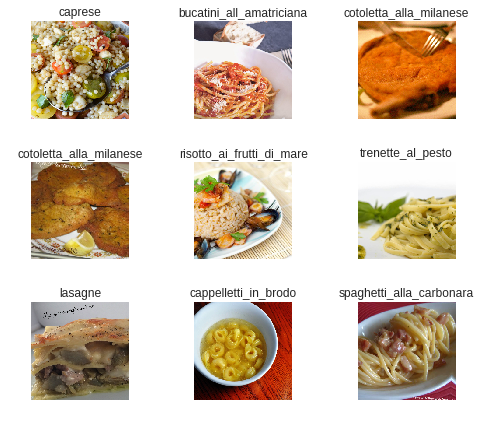

In [10]:
data.show_batch(rows=3, figsize=(7,6))

In [11]:
print(data.classes)
len(data.classes),data.c

['bucatini_all_amatriciana', 'cappelletti_in_brodo', 'caprese', 'coda_alla_vaccinara', 'cotoletta_alla_milanese', 'lasagne', 'risotto_ai_frutti_di_mare', 'risotto_ai_funghi', 'risotto_alla_milanese', 'spaghetti_alla_carbonara', 'tagliatelle_al_ragu', 'tonnarelli_cacio_e_pepe', 'trenette_al_pesto']


(13, 13)

## Training: resnet34

Iniziamo il training

In [13]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 50259624.72it/s]


In [14]:
learn.fit_one_cycle(5)

Total time: 14:00
epoch  train_loss  valid_loss  error_rate
1      2.082765    0.773872    0.224138    (02:44)
2      1.233389    0.467133    0.150862    (02:49)
3      0.848746    0.406835    0.131466    (02:46)
4      0.623826    0.389474    0.131466    (02:46)
5      0.503675    0.373706    0.133621    (02:53)



Salviamo il modello addestrato


In [0]:
learn.save('stage-1')

## Results

Let's see what results we have got. 

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly. 

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

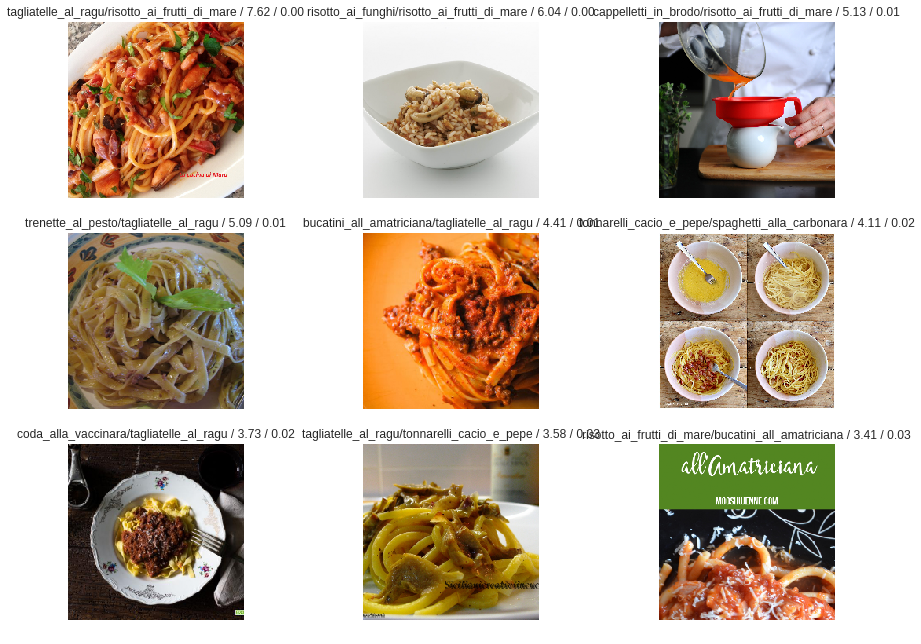

In [17]:
interp.plot_top_losses(9, figsize=(15,11))

In [0]:
doc(interp.plot_top_losses)

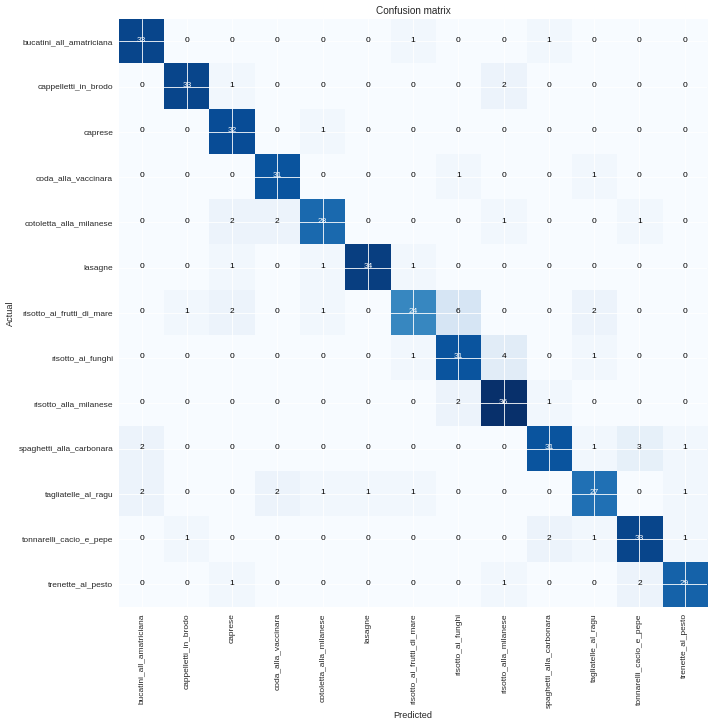

In [18]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [19]:
interp.most_confused(min_val=2)

[('risotto_ai_frutti_di_mare', 'risotto_ai_funghi', 6),
 ('risotto_ai_funghi', 'risotto_alla_milanese', 4),
 ('spaghetti_alla_carbonara', 'tonnarelli_cacio_e_pepe', 3)]

## Training: resnet50

Now we will train in the same way as before but with one caveat: instead of using resnet34 as our backbone we will use resnet50 (resnet34 is a 34 layer residual network while resnet50 has 50 layers. Later in the course you can learn the details in the [resnet paper](https://arxiv.org/pdf/1512.03385.pdf)).

Basically, resnet50 usually performs better because it is a deeper network with more parameters. Let's see if we can achieve a higher performance here.

In [20]:
data = ImageDataBunch.from_folder(path, ds_tfms=get_transforms(), size=299, bs=32)
data.normalize(imagenet_stats)

In [22]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 69323003.78it/s]


In [23]:
learn.fit_one_cycle(4)

Total time: 12:06
epoch  train_loss  valid_loss  error_rate
1      1.037402    0.379816    0.122845    (03:16)
2      0.563621    0.319422    0.086207    (02:56)
3      0.394538    0.258210    0.068966    (02:57)
4      0.282682    0.257809    0.073276    (02:56)



In [0]:
learn.save('stage-1-50')

In [0]:
learn.load('stage-1-50')

It's astonishing that it's possible to recognize pet breeds so accurately! Let's see if full fine-tuning helps:

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

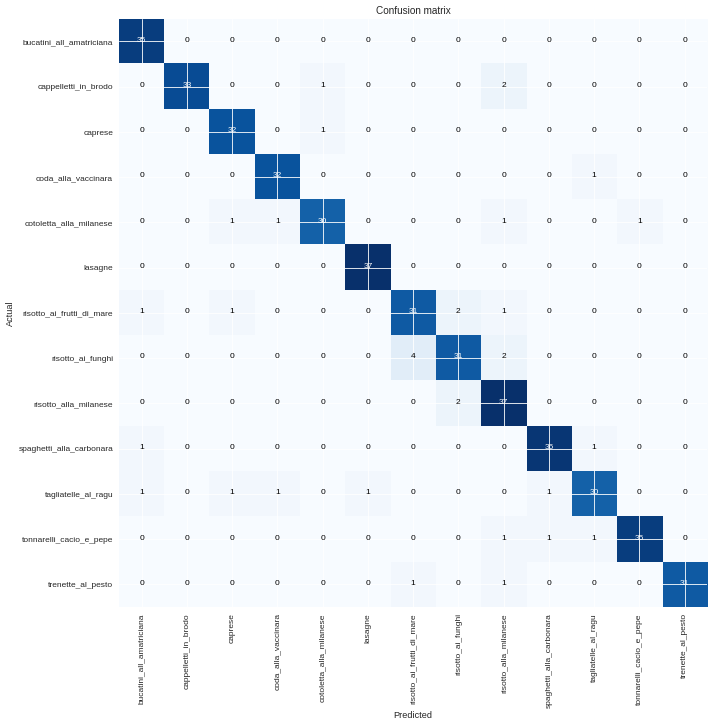

In [27]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [28]:
interp.most_confused(min_val=1)

[('risotto_ai_funghi', 'risotto_ai_frutti_di_mare', 4),
 ('cappelletti_in_brodo', 'risotto_alla_milanese', 2),
 ('risotto_ai_frutti_di_mare', 'risotto_ai_funghi', 2),
 ('risotto_ai_funghi', 'risotto_alla_milanese', 2),
 ('risotto_alla_milanese', 'risotto_ai_funghi', 2)]

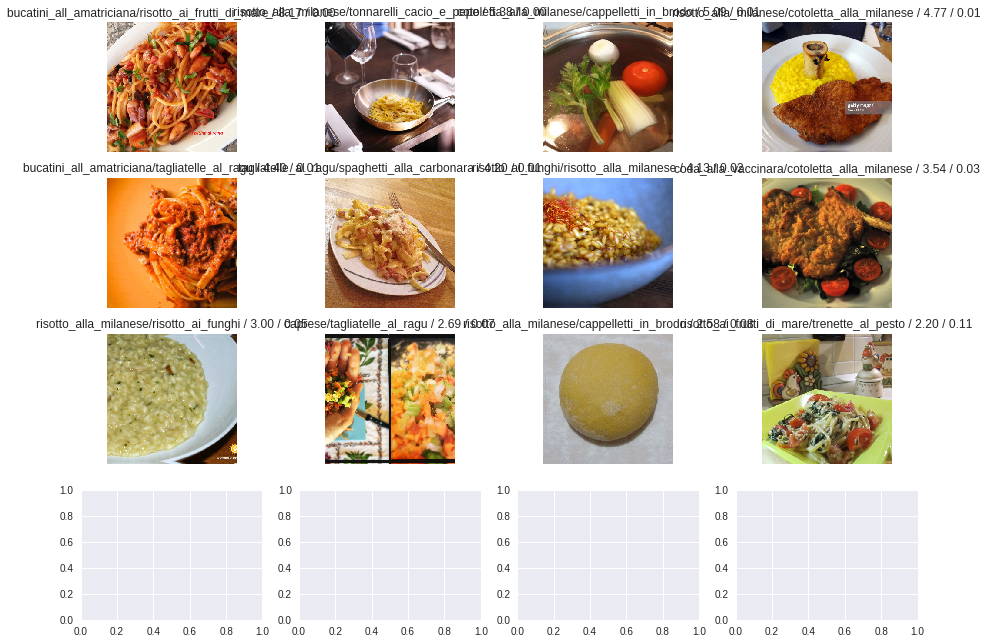

In [29]:
interp.plot_top_losses(12, figsize=(15,11))

In [30]:
learn.data.classes[open_image('./storage/data/italianfooddataset/valid/caprese/108.jpg').predict(learn).argmax()]

'caprese'

In [31]:
learn.data.classes[open_image('./storage/data/IMG_20181028_195411820.jpg').predict(learn).argmax()]

'risotto_ai_frutti_di_mare'